In [89]:
import sys
from pathlib import Path
import pandas as pd

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "src").exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd().resolve())
print("PROJECT_ROOT =", PROJECT_ROOT)

# Ensure results folder exists
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

# Make imports work (because your file is in PROJECT_ROOT/src/src/...)
sys.path.insert(0, str(PROJECT_ROOT / "src"))

PROJECT_ROOT = C:\Users\Ahana\Desktop\Analysis-for-Accurate-Estimation-of-GPS-Signal-Delays


In [21]:
import importlib
import src.cggtts_utils as cu
importlib.reload(cu)

print("Using:", cu.__file__)

df = cu.load_all_excels(PROJECT_ROOT / "data")
weather_df = pd.read_excel(PROJECT_ROOT / "data" / "0_Feb-April_Weather Data.xlsx")

df.shape, df.head()

Using: C:\Users\Ahana\Desktop\Analysis-for-Accurate-Estimation-of-GPS-Signal-Delays\src\src\cggtts_utils.py
Skipping file (missing/invalid columns or STTIME): 0_Feb-April_Weather Data.xlsx


((22119, 10),
              datetime      MJD  STTIME  SAT  ELV  AZTH       REFSYS  month  \
 0 2024-04-01 10:34:00  60401.0  103400  G13  468  1607 -134008498.0  April   
 1 2024-04-01 10:34:00  60401.0  103400  G15  312  2021 -133953148.0  April   
 2 2024-04-01 10:34:00  60401.0  103400  G17  224  1219 -134012460.0  April   
 3 2024-04-01 10:34:00  60401.0  103400  G19  402  1022 -134011825.0  April   
 4 2024-04-01 10:34:00  60401.0  103400  G22  179  1571 -134012469.0  April   
 
   dataset                   source_file  
 0   Set 1  April_CGGTTS_Data Set 1.xlsx  
 1   Set 1  April_CGGTTS_Data Set 1.xlsx  
 2   Set 1  April_CGGTTS_Data Set 1.xlsx  
 3   Set 1  April_CGGTTS_Data Set 1.xlsx  
 4   Set 1  April_CGGTTS_Data Set 1.xlsx  )

In [22]:
df["month"].value_counts(), df["dataset"].value_counts() # To check the presence of all data from the existing files

(month
 March    8328
 April    7653
 Feb      6138
 Name: count, dtype: int64,
 dataset
 Set 2    17679
 Set 1     4440
 Name: count, dtype: int64)

In [69]:
from pathlib import Path
import matplotlib.pyplot as plt

RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(exist_ok=True)

_original_show = plt.show
_counter = 1

def autosave_show(*args, **kwargs):
    global _counter
    for fig_num in plt.get_fignums():
        fig = plt.figure(fig_num)
        fig.savefig(RESULTS_DIR / f"plot_{_counter}.png", dpi=200, bbox_inches="tight")
        _counter += 1
    _original_show(*args, **kwargs)

plt.show = autosave_show

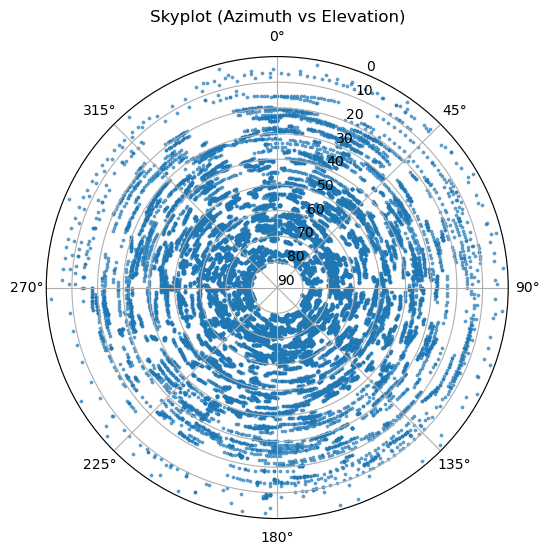

In [70]:
# Skyplot style (AZTH vs ELV)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sub = df.copy()

# Convert to numeric
sub["ELV"]  = pd.to_numeric(sub["ELV"], errors="coerce") / 10   # <<< FIX SCALE
sub["AZTH"] = pd.to_numeric(sub["AZTH"], errors="coerce")

sub = sub.dropna(subset=["ELV","AZTH"])

# Keep only physically valid angles
sub = sub[(sub["ELV"] >= 0) & (sub["ELV"] <= 90)]

theta = np.deg2rad(sub["AZTH"].to_numpy())
r = 90 - sub["ELV"].to_numpy()

plt.figure(figsize=(6,6))
ax = plt.subplot(111, projection="polar")
ax.scatter(theta, r, s=3, alpha=0.6)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(90, 0)

ax.set_title("Skyplot (Azimuth vs Elevation)")
plt.show()


Processing satellite motion for Feb (2024-02-03)


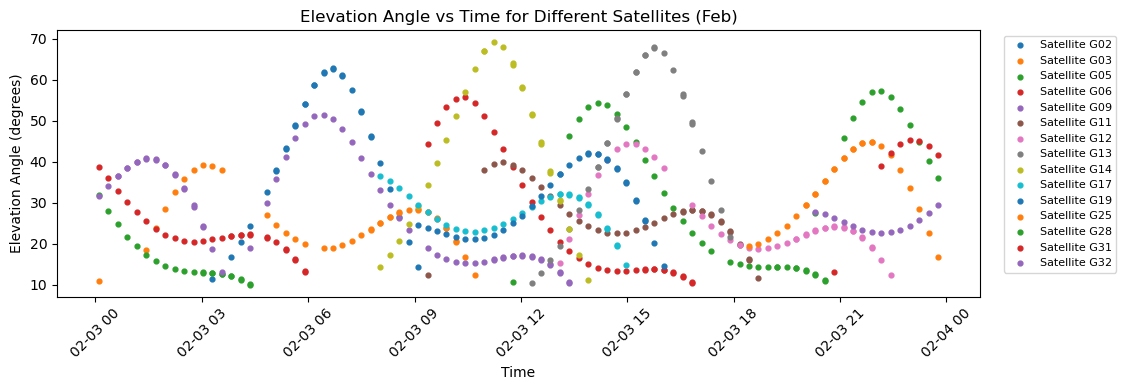

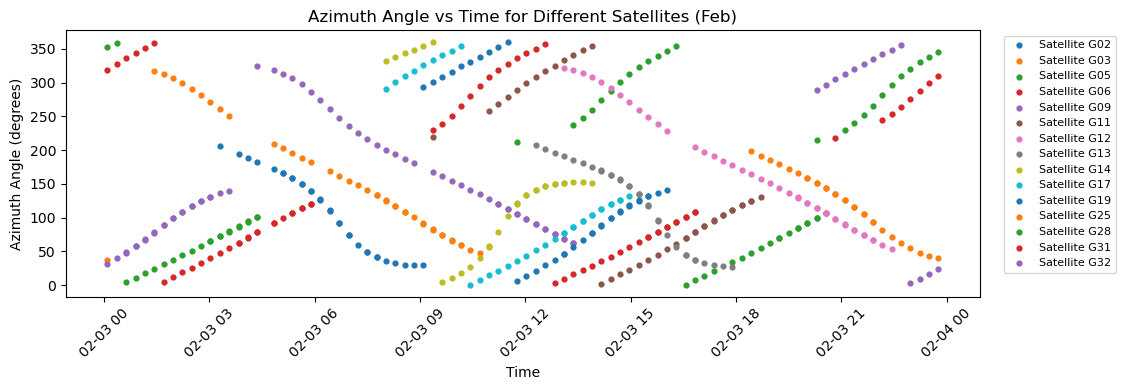


Processing satellite motion for March (2024-03-24)


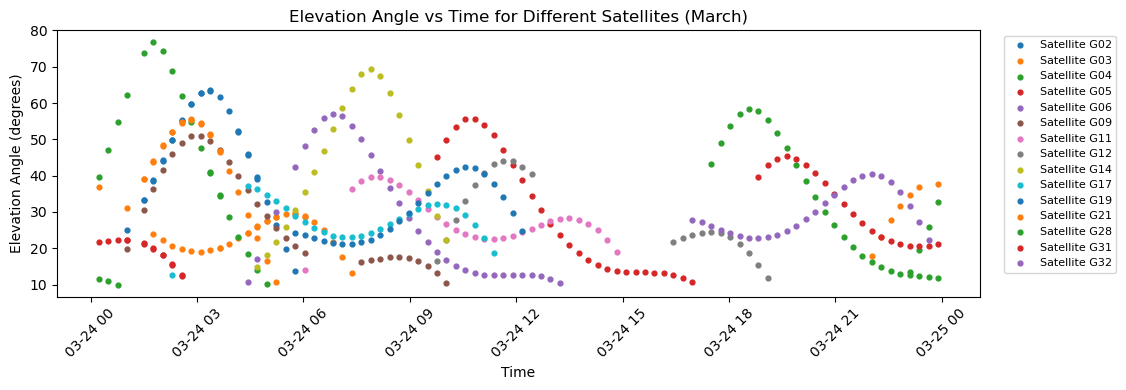

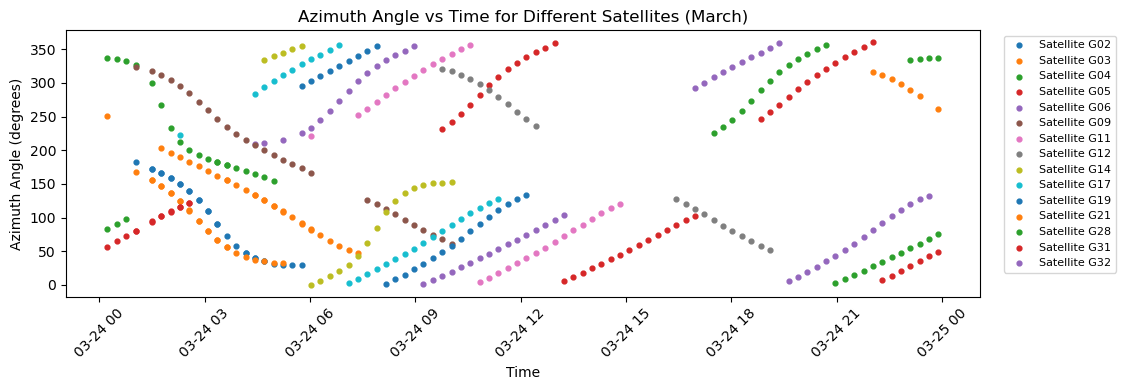


Processing satellite motion for April (2024-04-01)


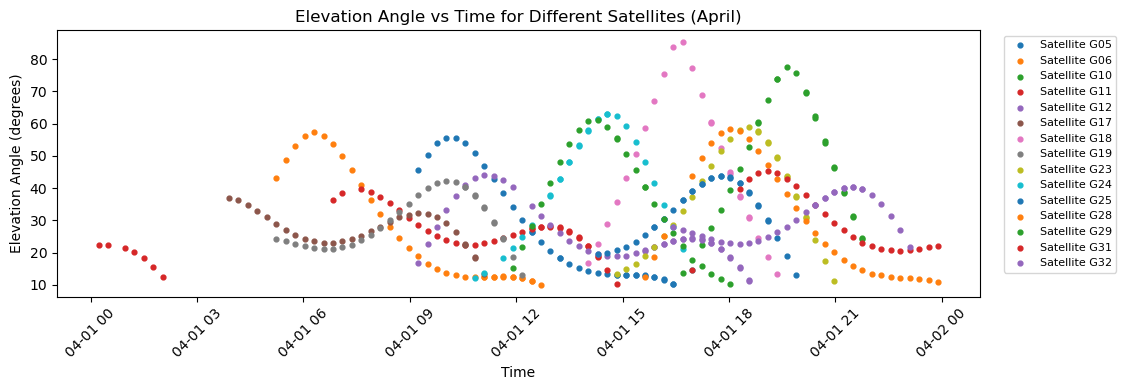

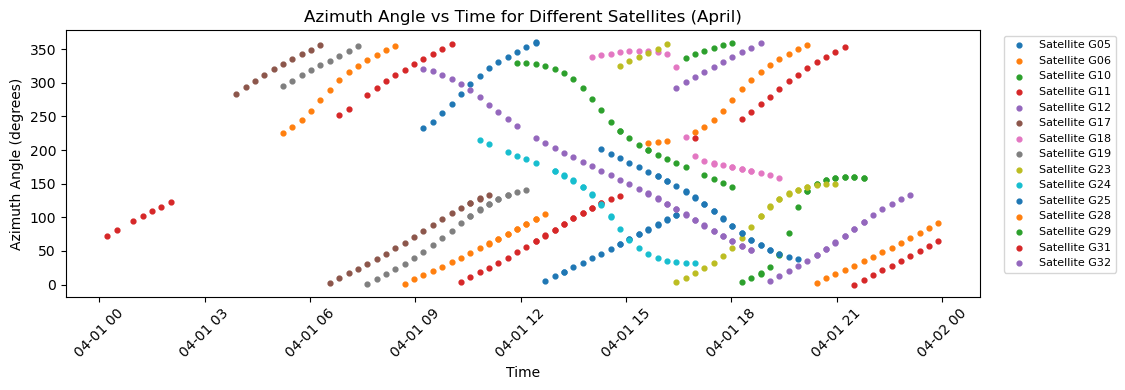

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# This analysis visualises satellite movement for one day
# from each month to observe:
# - Elevation angle behaviour over time
# - Azimuth angle trajectories over time
#
# This confirms:
# satellites were successfully tracked
# angular motion follows realistic orbital paths
# geometry changes across months (important for delay variation)


# Selecting one representative day from each month 
selected_days = {
    "Feb": "2024-02-03",
    "March": "2024-03-24",
    "April": "2024-04-01"
}

# Limit number of satellites so plots remain readable
TOP_N_SATS = 15


# Convert raw CGGTTS angular values into degrees
# CGGTTS stores angles scaled by 10 (example: 468 = 46.8°)

df["ELV_deg"] = pd.to_numeric(df["ELV"], errors="coerce") / 10
df["AZTH_deg"] = pd.to_numeric(df["AZTH"], errors="coerce") / 10

# Remove invalid rows
df = df.dropna(subset=["datetime", "SAT", "ELV_deg", "AZTH_deg"])

# Physically meaningful limits
df = df[(df["ELV_deg"] >= 0) & (df["ELV_deg"] <= 90)]
df = df[(df["AZTH_deg"] >= 0) & (df["AZTH_deg"] <= 360)]


# LOOP THROUGH EACH MONTH’S REPRESENTATIVE DAY

for month, day in selected_days.items():

    print(f"\nProcessing satellite motion for {month} ({day})")

    sub = df[df["datetime"].dt.date == pd.to_datetime(day).date()].copy()

    # Choose most observed satellites for clean trajectories
    top_sats = sub["SAT"].value_counts().head(TOP_N_SATS).index
    sub = sub[sub["SAT"].isin(top_sats)]

    sub = sub.sort_values("datetime")


    # ELEVATION ANGLE VS TIME
    
    plt.figure(figsize=(10,4))

    for sat, ssub in sub.groupby("SAT"):
        plt.scatter(
            ssub["datetime"],
            ssub["ELV_deg"],
            s=12,
            label=f"Satellite {sat}"
        )

    plt.xlabel("Time")
    plt.ylabel("Elevation Angle (degrees)")
    plt.title(f"Elevation Angle vs Time for Different Satellites ({month})")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        fontsize=8
    )

    plt.savefig(f"../results/elevation_vs_time_{month}.png", dpi=200, bbox_inches="tight")
    plt.show()

    # AZIMUTH ANGLE VS TIME

    plt.figure(figsize=(10,4))

    for sat, ssub in sub.groupby("SAT"):
        plt.scatter(
            ssub["datetime"],
            ssub["AZTH_deg"],
            s=12,
            label=f"Satellite {sat}"
        )

    plt.xlabel("Time")
    plt.ylabel("Azimuth Angle (degrees)")
    plt.title(f"Azimuth Angle vs Time for Different Satellites ({month})")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend(
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        fontsize=8
    )

    plt.savefig(f"../results/azimuth_vs_time_{month}.png", dpi=200, bbox_inches="tight")
    plt.show()

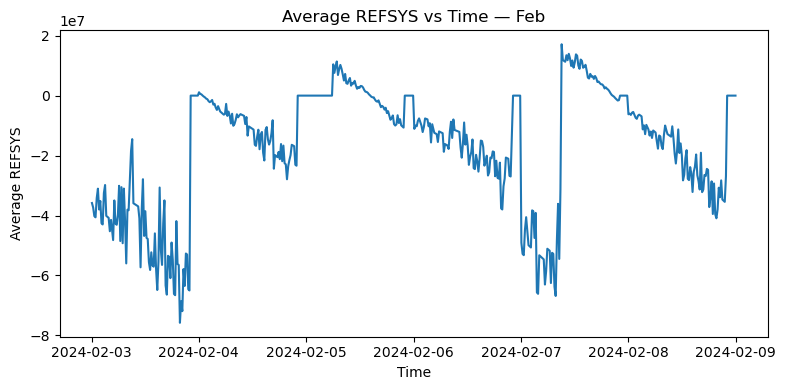

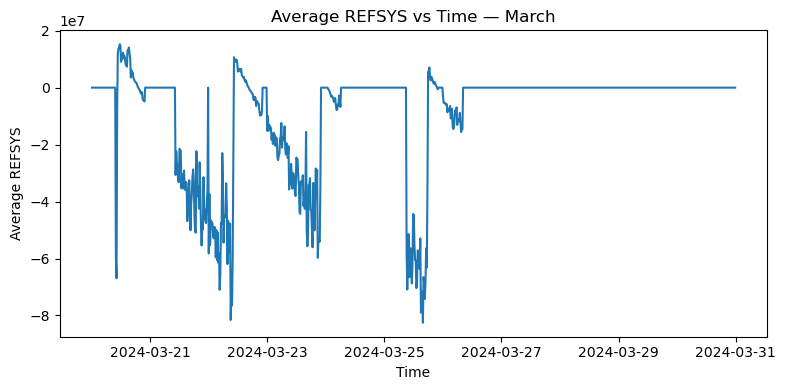

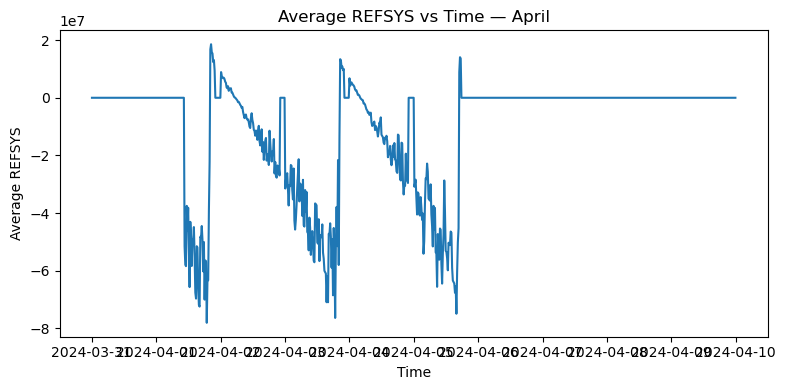

In [72]:
# Average REFSYS vs Time (Individual Months)

import matplotlib.pyplot as plt

# Sort by time (important for clean plots)
df_sorted = df.sort_values("datetime")

# Loop through each month separately
for m in ["Feb", "March", "April"]:

    month_df = df_sorted[df_sorted["month"] == m]

    # Average REFSYS at each timestamp
    avg_refsys = (
        month_df.groupby("datetime")["REFSYS"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8,4))
    plt.plot(avg_refsys["datetime"], avg_refsys["REFSYS"])
    plt.xlabel("Time")
    plt.ylabel("Average REFSYS")
    plt.title(f"Average REFSYS vs Time — {m}")
    plt.tight_layout()
    plt.show()

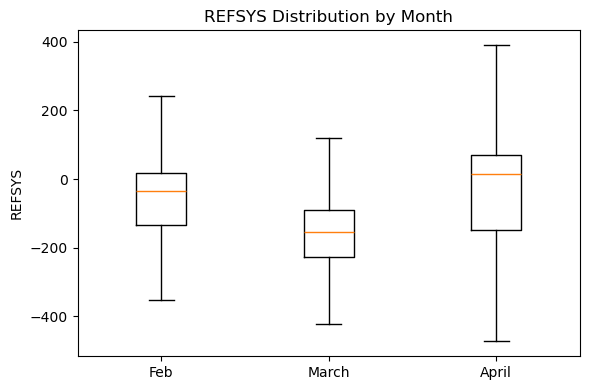

In [73]:
import matplotlib.pyplot as plt

mcol = "MONTH" if "MONTH" in df.columns else "month"

data = [
    df[df[mcol] == "Feb"]["REFSYS"].dropna(),
    df[df[mcol] == "March"]["REFSYS"].dropna(),
    df[df[mcol] == "April"]["REFSYS"].dropna(),
]

plt.figure(figsize=(6,4))
plt.boxplot(data, tick_labels=["Feb", "March", "April"], showfliers=False)
plt.ylabel("REFSYS")
plt.title("REFSYS Distribution by Month")
plt.tight_layout()
plt.show()

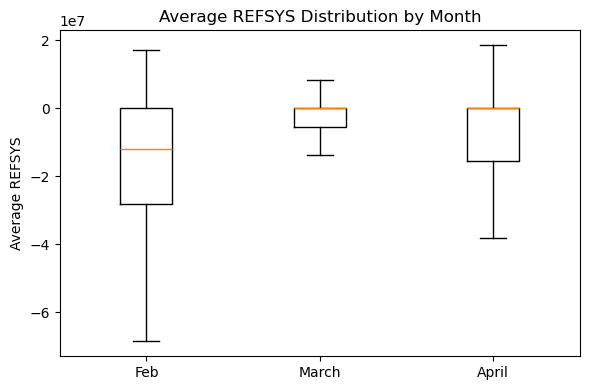

In [74]:
import matplotlib.pyplot as plt

mcol = "MONTH" if "MONTH" in df.columns else "month"
dtcol = "DATETIME" if "DATETIME" in df.columns else "datetime"

avg_feb = df[df[mcol] == "Feb"].groupby(dtcol)["REFSYS"].mean().dropna()
avg_mar = df[df[mcol] == "March"].groupby(dtcol)["REFSYS"].mean().dropna()
avg_apr = df[df[mcol] == "April"].groupby(dtcol)["REFSYS"].mean().dropna()

avg_data = [avg_feb, avg_mar, avg_apr]

plt.figure(figsize=(6,4))
plt.boxplot(avg_data, tick_labels=["Feb", "March", "April"], showfliers=False)
plt.ylabel("Average REFSYS")
plt.title("Average REFSYS Distribution by Month")
plt.tight_layout()
plt.show()

PROJECT_ROOT = C:\Users\Ahana\Desktop\Analysis-for-Accurate-Estimation-of-GPS-Signal-Delays
Skipping file (missing/invalid columns or STTIME): 0_Feb-April_Weather Data.xlsx
Loaded shape: (22119, 10)


,datetime,MJD,STTIME,SAT,ELV,AZTH,REFSYS,month,dataset,source_file
0,2024-04-01 10:34:00,60401.0,103400,G13,468,1607,-134008498.0,April,Set 1,April_CGGTTS_Data Set 1.xlsx
1,2024-04-01 10:34:00,60401.0,103400,G15,312,2021,-133953148.0,April,Set 1,April_CGGTTS_Data Set 1.xlsx
2,2024-04-01 10:34:00,60401.0,103400,G17,224,1219,-134012460.0,April,Set 1,April_CGGTTS_Data Set 1.xlsx
3,2024-04-01 10:34:00,60401.0,103400,G19,402,1022,-134011825.0,April,Set 1,April_CGGTTS_Data Set 1.xlsx
4,2024-04-01 10:34:00,60401.0,103400,G22,179,1571,-134012469.0,April,Set 1,April_CGGTTS_Data Set 1.xlsx



Time points per month & dataset:
month  dataset
April  Set 1      354
       Set 2      893
Feb    Set 1      470
       Set 2      536
March  Set 1      357
       Set 2      981
dtype: int64


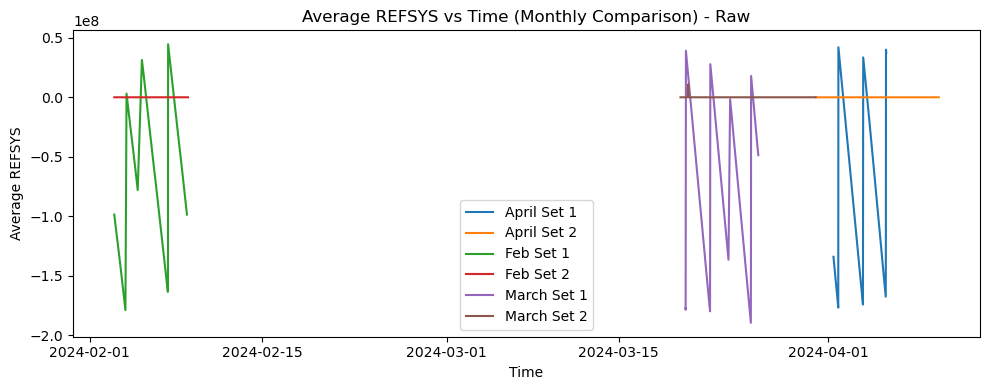

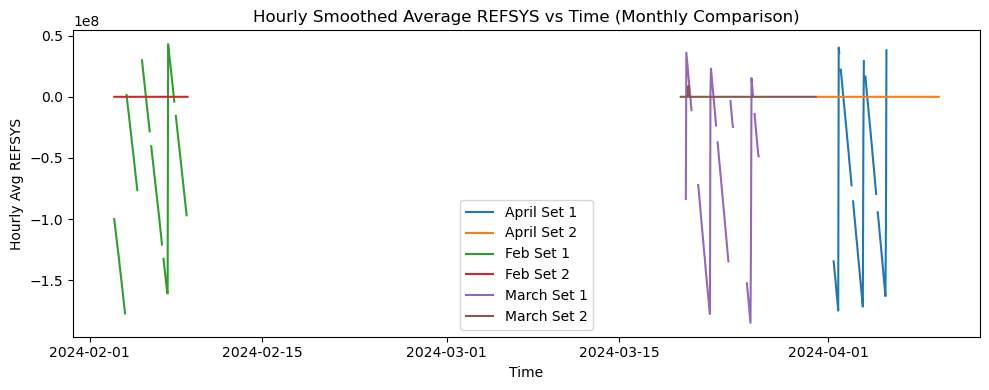

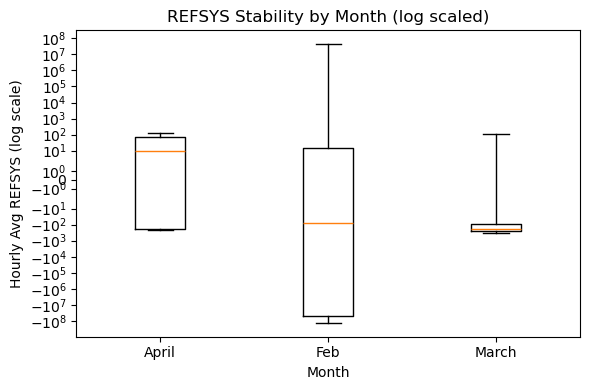


Saved plots to: C:\Users\Ahana\Desktop\Analysis-for-Accurate-Estimation-of-GPS-Signal-Delays\results
 - hourly_refsys_trend.png
 - refsys_monthly_boxplot.png

Monthly summary (hourly averaged):


,count,mean,std,median,min,max
month,,,,,,
April,336,-2.202724e+07,4.829951e+07,9.432292,-1.748837e+08,4.024214e+07
Feb,270,-2.928677e+07,5.058958e+07,-75.164881,-1.771800e+08,4.299907e+07
March,362,-1.835891e+07,4.495726e+07,-175.030952,-1.848744e+08,3.615032e+07


In [75]:
# To check the average REFSYS Trend

import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# 1) Find project root robustly 
def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "src").exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd().resolve())
print("PROJECT_ROOT =", PROJECT_ROOT)

# 2) Make src import work
sys.path.insert(0, str(PROJECT_ROOT / "src"))
from src.cggtts_utils import load_all_excels

# 3) Load data
DATA_DIR = PROJECT_ROOT / "data"
df = load_all_excels(DATA_DIR)

print("Loaded shape:", df.shape)
display(df.head())

# 4) Use correct column names 
dtcol = "DATETIME" if "DATETIME" in df.columns else "datetime"
mcol  = "MONTH" if "MONTH" in df.columns else "month"
dscol = "DATASET" if "DATASET" in df.columns else "dataset"

# 5) Aggregate: average REFSYS across satellites at each timestamp 
agg = (
    df.sort_values(dtcol)
      .groupby([mcol, dscol, dtcol], as_index=False)["REFSYS"]
      .mean()
)

print("\nTime points per month & dataset:")
print(agg.groupby([mcol, dscol]).size())

# 6) Plot A: Raw average REFSYS vs time
plt.figure(figsize=(10,4))
for (m, dset), sub in agg.groupby([mcol, dscol]):
    plt.plot(sub[dtcol], sub["REFSYS"], label=f"{m} {dset}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average REFSYS")
plt.title("Average REFSYS vs Time (Monthly Comparison) - Raw")
plt.tight_layout()
plt.show()

# 7) Smooth trend correctly 
hourly = (
    agg.set_index(dtcol)
       .groupby([mcol, dscol])
       .resample("1h")["REFSYS"]
       .mean()
       .reset_index()
)

# 8) Plot B: Hourly smoothed average 
plt.figure(figsize=(10,4))
for (m, dset), sub in hourly.groupby([mcol, dscol]):
    plt.plot(sub[dtcol], sub["REFSYS"], label=f"{m} {dset}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Hourly Avg REFSYS")
plt.title("Hourly Smoothed Average REFSYS vs Time (Monthly Comparison)")
plt.tight_layout()
plt.show()

# 9) Plot C: Boxplot per month 
months = sorted(hourly[mcol].dropna().unique())
box_data = [hourly.loc[hourly[mcol] == m, "REFSYS"].dropna().values for m in months]

plt.figure(figsize=(6,4))
plt.boxplot(box_data, tick_labels=months, showfliers=False)
plt.yscale("symlog")   # handles positives + negatives nicely
plt.xlabel("Month")
plt.ylabel("Hourly Avg REFSYS (log scale)")
plt.title("REFSYS Stability by Month (log scaled)")
plt.tight_layout()
plt.show()

# 10) Save figures into /results (portable path) 
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

# Save hourly trend plot
plt.figure(figsize=(10,4))
for (m, dset), sub in hourly.groupby([mcol, dscol]):
    plt.plot(sub[dtcol], sub["REFSYS"], label=f"{m} {dset}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Hourly Avg REFSYS")
plt.title("Hourly Smoothed Average REFSYS vs Time (Monthly Comparison)")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "hourly_refsys_trend.png", dpi=200)
plt.close()

# Save boxplot
plt.figure(figsize=(6,4))
plt.boxplot(box_data, tick_labels=months, showfliers=False)
plt.xlabel("Month")
plt.ylabel("Hourly Avg REFSYS")
plt.title("REFSYS Distribution by Month (Stability Comparison)")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "refsys_monthly_boxplot.png", dpi=200)
plt.close()

print("\nSaved plots to:", RESULTS_DIR)
print(" - hourly_refsys_trend.png")
print(" - refsys_monthly_boxplot.png")

# 11) Summary Statistics
summary = (
    hourly.groupby(mcol)["REFSYS"]
          .agg(count="count", mean="mean", std="std", median="median", min="min", max="max")
          .sort_index()
)

print("\nMonthly summary (hourly averaged):")
display(summary)

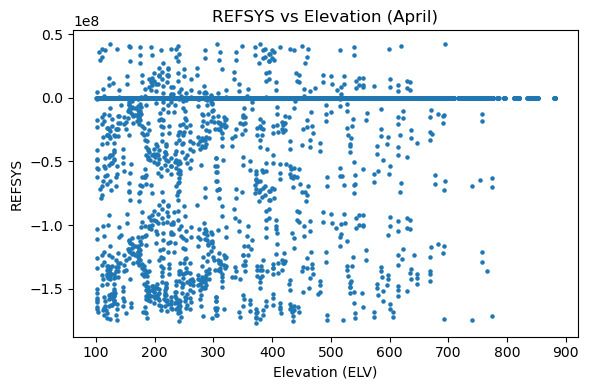

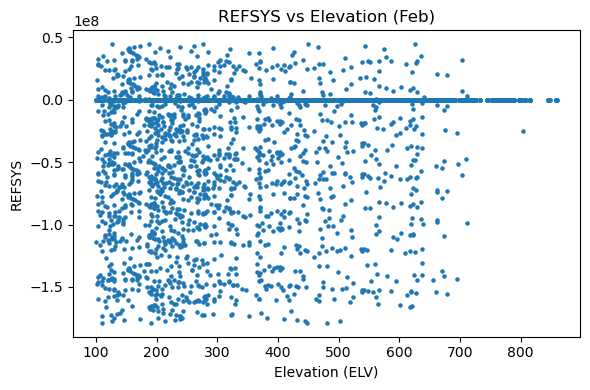

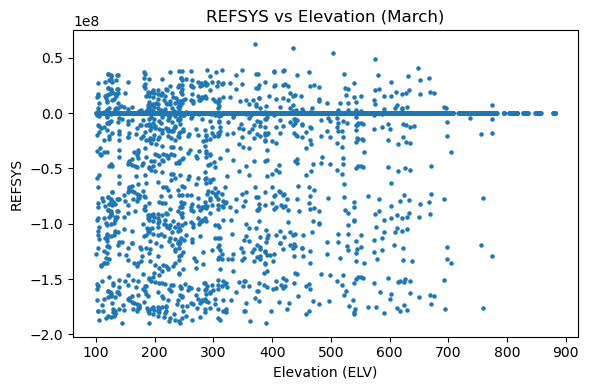

In [76]:
# Comparison of REFSYS vs Elevation (ELV)
# Lower elevation = less noisy 

# Scatter Plot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for m in sorted(df["month"].unique()):
    sub = df[df["month"] == m].copy()

    # Force numeric (turn junk into NaN), then drop NaNs
    sub["ELV"] = pd.to_numeric(sub["ELV"], errors="coerce")
    sub["REFSYS"] = pd.to_numeric(sub["REFSYS"], errors="coerce")
    sub = sub.dropna(subset=["ELV", "REFSYS"])

    # Convert to plain numpy arrays (matplotlib likes this)
    x = sub["ELV"].to_numpy(dtype=float)
    y = sub["REFSYS"].to_numpy(dtype=float)

    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=5)
    plt.xlabel("Elevation (ELV)")
    plt.ylabel("REFSYS")
    plt.title(f"REFSYS vs Elevation ({m})")
    plt.tight_layout()
    plt.show()

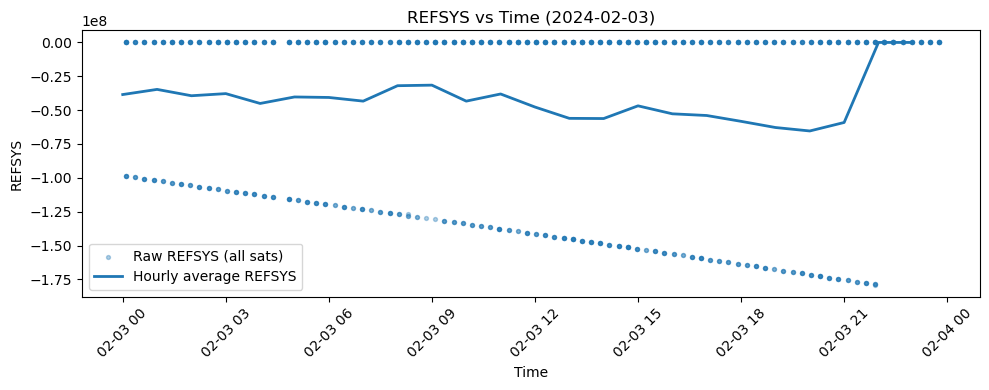

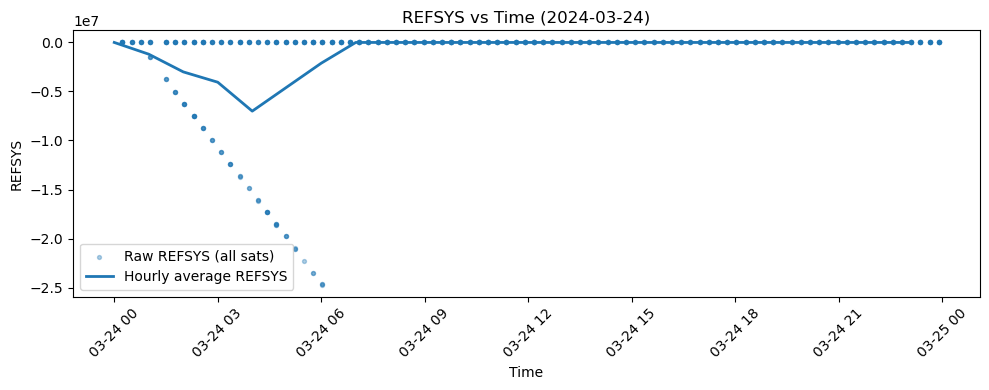

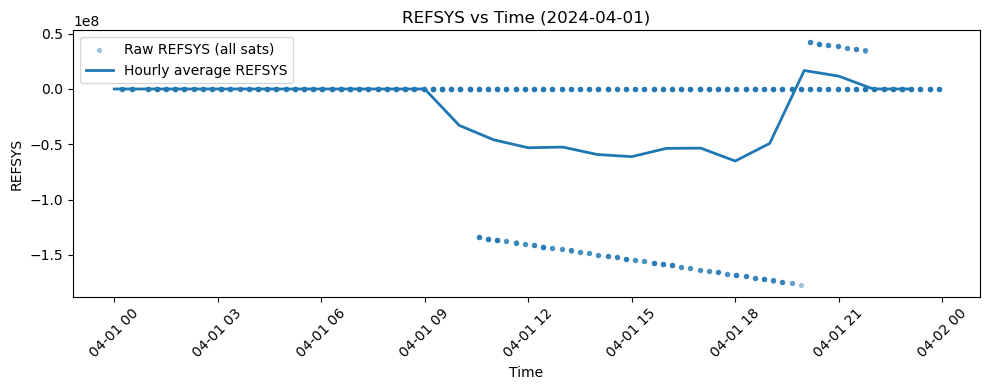

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# REFSYS vs Time for specific days
# - Scatter: raw REFSYS measurements (all satellites)
# - Line: hourly average to show the trend clearly

days_to_plot = [
    ("Feb03",  "2024-02-03"),
    ("Mar24",  "2024-03-24"),
    ("Apr01",  "2024-04-01"),
]

for tag, day in days_to_plot:
    # 1) Filter to the day 
    sub = df[df["datetime"].dt.date == pd.to_datetime(day).date()].copy()

    # 2) To ensure REFSYS is numeric
    sub["REFSYS"] = pd.to_numeric(sub["REFSYS"], errors="coerce")
    sub = sub.dropna(subset=["datetime", "REFSYS"]).sort_values("datetime")

    if sub.empty:
        print(f"No data found for {day}. Check if that month is loaded in /data.")
        continue

    # 3) Create hourly average trend 
    hourly = (
        sub.set_index("datetime")["REFSYS"]
           .resample("1h")
           .mean()
           .dropna()
    )

    # 4) Plot 
    plt.figure(figsize=(10,4))

    # Raw scatter (all sats)
    plt.scatter(sub["datetime"], sub["REFSYS"], s=8, alpha=0.35, label="Raw REFSYS (all sats)")

    # Smoothed hourly mean
    plt.plot(hourly.index, hourly.values, linewidth=2, label="Hourly average REFSYS")

    plt.xlabel("Time")
    plt.ylabel("REFSYS")
    plt.title(f"REFSYS vs Time ({day})")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.savefig(f"../results/refsys_vs_time_{tag}_{day}.png", dpi=200, bbox_inches="tight")
    plt.show()

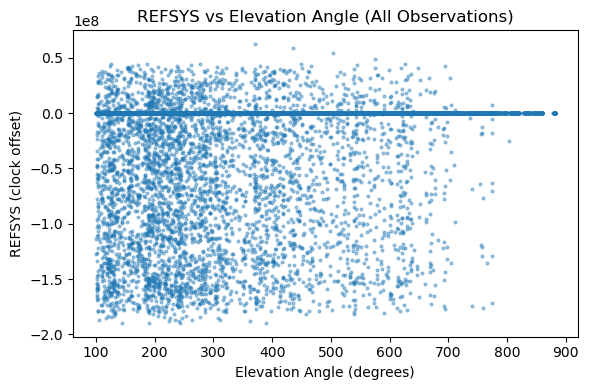

In [78]:
# REFSYS vs Elevation
# To check signal quality

df["ELV"] = pd.to_numeric(df["ELV"], errors="coerce")
df["REFSYS"] = pd.to_numeric(df["REFSYS"], errors="coerce")

df = df.dropna(subset=["ELV", "REFSYS"])
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.scatter(
    df["ELV"],
    df["REFSYS"],
    s=4,
    alpha=0.4
)

plt.xlabel("Elevation Angle (degrees)")
plt.ylabel("REFSYS (clock offset)")
plt.title("REFSYS vs Elevation Angle (All Observations)")
plt.tight_layout()
plt.show()

,REFSYS,tavg,tmax,tmin,prcp,pres,wspd
0,-98533740.0,28.5,32.2,26.2,9.5,1013.0,15.7
1,8.0,28.5,32.2,26.2,9.5,1013.0,15.7
2,-2.0,28.5,32.2,26.2,9.5,1013.0,15.7
3,-17.0,28.5,32.2,26.2,9.5,1013.0,15.7
4,8.0,28.5,32.2,26.2,9.5,1013.0,15.7


          REFSYS      tavg      tmax      tmin      prcp      pres      wspd
REFSYS  1.000000  0.114740  0.123634  0.114214  0.079641 -0.023852 -0.127528
tavg    0.114740  1.000000  0.757347  0.882474 -0.190701 -0.687623 -0.181627
tmax    0.123634  0.757347  1.000000  0.500564 -0.265718 -0.622117 -0.194948
tmin    0.114214  0.882474  0.500564  1.000000 -0.012094 -0.617821 -0.203101
prcp    0.079641 -0.190701 -0.265718 -0.012094  1.000000  0.134882 -0.579141
pres   -0.023852 -0.687623 -0.622117 -0.617821  0.134882  1.000000  0.322108
wspd   -0.127528 -0.181627 -0.194948 -0.203101 -0.579141  0.322108  1.000000


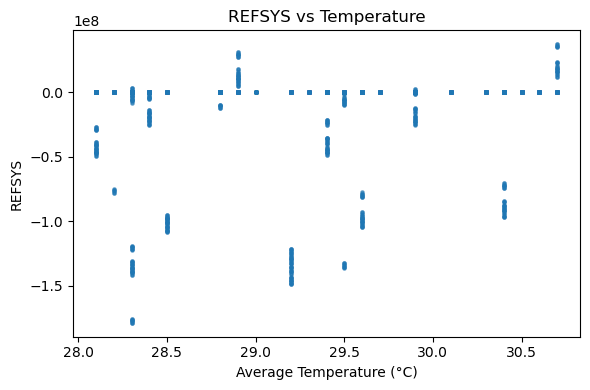

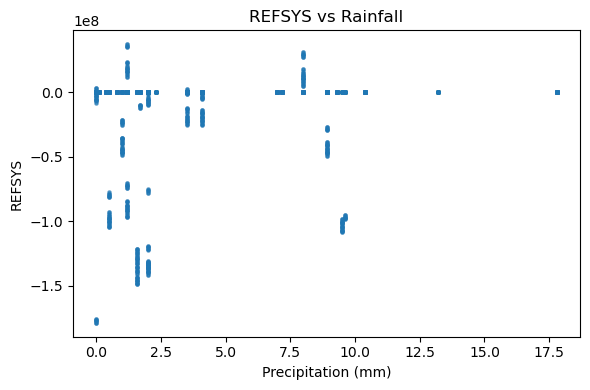

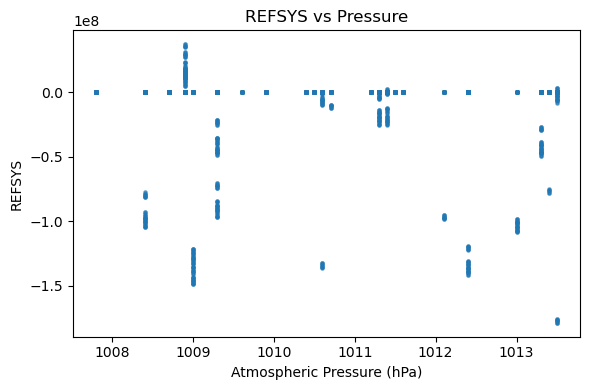

In [79]:
# To check impact of Weather Conditions on REFSYS Signal Delay

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# paths 
WEATHER_PATH = PROJECT_ROOT / "data" / "0_Feb-April_Weather Data.xlsx"
weather = pd.read_excel(WEATHER_PATH)

# column names 
dtcol = "DATETIME" if "DATETIME" in df.columns else "datetime"

# weather datetime formatting
weather["datetime"] = pd.to_datetime(weather["date"], errors="coerce")
weather = weather.drop(columns=["date"], errors="ignore")
weather = weather.dropna(subset=["datetime"]).sort_values("datetime")
weather = weather.drop_duplicates(subset=["datetime"])

# merge
merged = pd.merge_asof(
    df.sort_values(dtcol).rename(columns={dtcol: "datetime"}),  # unify name for merge
    weather,
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("3h")  # only match if within 3 hours
)

cols_to_show = ["REFSYS", "tavg", "tmax", "tmin", "prcp", "pres", "wspd"]
available = [c for c in cols_to_show if c in merged.columns]
display(merged[available].head())

# correlations
corr_cols = [c for c in ["REFSYS", "tavg", "tmax", "tmin", "prcp", "pres", "wspd"] if c in merged.columns]
print(merged[corr_cols].corr(numeric_only=True))

# scatter helper
def scatter(xcol, ycol="REFSYS", xlabel=None, title=None):
    tmp = merged[[xcol, ycol]].dropna()
    plt.figure(figsize=(6,4))
    plt.scatter(tmp[xcol], tmp[ycol], s=5, alpha=0.4)
    plt.xlabel(xlabel or xcol)
    plt.ylabel(ycol)
    plt.title(title or f"{ycol} vs {xcol}")
    plt.tight_layout()
    plt.show()

# REFSYS vs Temperature
if "tavg" in merged.columns:
    scatter("tavg", xlabel="Average Temperature (°C)", title="REFSYS vs Temperature")

# REFSYS vs Precipitation
if "prcp" in merged.columns:
    scatter("prcp", xlabel="Precipitation (mm)", title="REFSYS vs Rainfall")

# REFSYS vs Pressure
if "pres" in merged.columns:
    scatter("pres", xlabel="Atmospheric Pressure (hPa)", title="REFSYS vs Pressure")

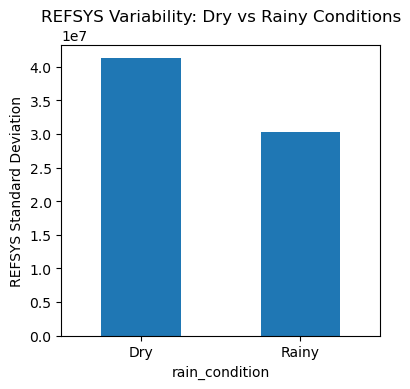

In [80]:
# To quantify how much rain increases REFSYS variability

# Define rainy vs dry
merged["rain_condition"] = merged["prcp"].apply(
    lambda x: "Rainy" if x > 0 else "Dry"
)

variability = merged.groupby("rain_condition")["REFSYS"].std()
variability

dry_std = variability["Dry"]
rain_std = variability["Rainy"]

increase_pct = ((rain_std - dry_std) / dry_std) * 100
increase_pct

variability.plot(kind="bar", figsize=(4,4))
plt.ylabel("REFSYS Standard Deviation")
plt.title("REFSYS Variability: Dry vs Rainy Conditions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

REFSYS variability (std) - Cool vs Hot:
temp_condition
Cool    4.075869e+07
Hot     2.215860e+07
Name: REFSYS, dtype: float64
Hot vs Cool change in variability: -45.63%


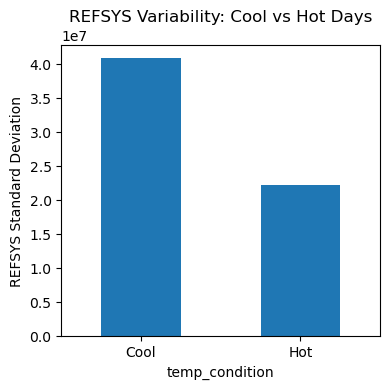

In [81]:
# To quantify how much temperature increases REFSYS variability

# Split days by median temperature
temp_median = merged["tavg"].median()
merged["temp_condition"] = merged["tavg"].apply(lambda x: "Hot" if x > temp_median else "Cool")

# Variability = standard deviation of REFSYS for each group
temp_variability = merged.groupby("temp_condition")["REFSYS"].std()
print("REFSYS variability (std) - Cool vs Hot:")
print(temp_variability)

# % change (Hot compared to Cool)
cool_std = temp_variability["Cool"]
hot_std  = temp_variability["Hot"]
temp_increase_pct = ((hot_std - cool_std) / cool_std) * 100
print(f"Hot vs Cool change in variability: {temp_increase_pct:.2f}%")

# Plot
temp_variability.plot(kind="bar", figsize=(4,4))
plt.ylabel("REFSYS Standard Deviation")
plt.title("REFSYS Variability: Cool vs Hot Days")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


REFSYS variability (std) - Low vs High Pressure:
pressure_condition
High    4.028755e+07
Low     3.073272e+07
Name: REFSYS, dtype: float64
High vs Low pressure change in variability: 31.09%


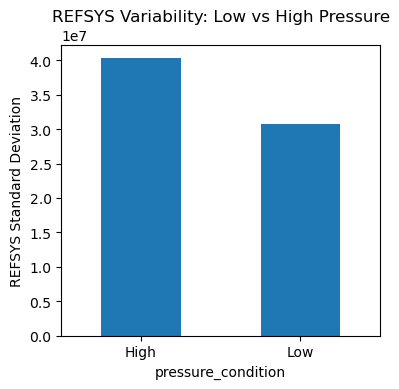

In [82]:
# To quantify how much pressure increases REFSYS variability

pres_median = merged["pres"].median()
merged["pressure_condition"] = merged["pres"].apply(lambda x: "Low" if x < pres_median else "High")

# Variability = standard deviation of REFSYS for each group
pres_variability = merged.groupby("pressure_condition")["REFSYS"].std()
print("\nREFSYS variability (std) - Low vs High Pressure:")
print(pres_variability)

# % change (High compared to Low)
low_std  = pres_variability["Low"]
high_std = pres_variability["High"]
pres_increase_pct = ((high_std - low_std) / low_std) * 100
print(f"High vs Low pressure change in variability: {pres_increase_pct:.2f}%")

# Plot
pres_variability.plot(kind="bar", figsize=(4,4))
plt.ylabel("REFSYS Standard Deviation")
plt.title("REFSYS Variability: Low vs High Pressure")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [83]:
import numpy as np
import pandas as pd

DT = "DATETIME" if "DATETIME" in agg.columns else "datetime"
M  = "MONTH" if "MONTH" in agg.columns else "month"
D  = "DATASET" if "DATASET" in agg.columns else "dataset"

hourly_df = (
    agg.set_index(DT)
       .groupby([M, D])
       .resample("1h")["REFSYS"]
       .mean()
       .reset_index()
)

# stability metrics
def stability_metrics(x):
    x = x.dropna()
    if len(x) < 3:
        return pd.Series({
            "count": len(x),
            "mean": np.nan,
            "std": np.nan,
            "iqr": np.nan,
            "mad": np.nan,
            "range_95_5": np.nan,
            "drift": np.nan
        })

    return pd.Series({
        "count": len(x),
        "mean": x.mean(),
        "std": x.std(),
        "iqr": x.quantile(.75) - x.quantile(.25),
        "mad": (x - x.median()).abs().median(),
        "range_95_5": x.quantile(.95) - x.quantile(.05),
        "drift": x.iloc[-1] - x.iloc[0]
    })

# computing per month
stability = (
    hourly_df.sort_values(DT)
             .groupby(M)["REFSYS"]
             .apply(stability_metrics)
             .reset_index()
             .set_index(M)
)

display(stability)

,level_1,REFSYS
month,,
April,count,3.360000e+02
April,mean,-2.202724e+07
April,std,4.829951e+07
April,iqr,2.731145e+02
April,mad,8.609896e+01
April,range_95_5,1.453264e+08
April,drift,3.116069e+02
Feb,count,2.700000e+02
Feb,mean,-2.928677e+07


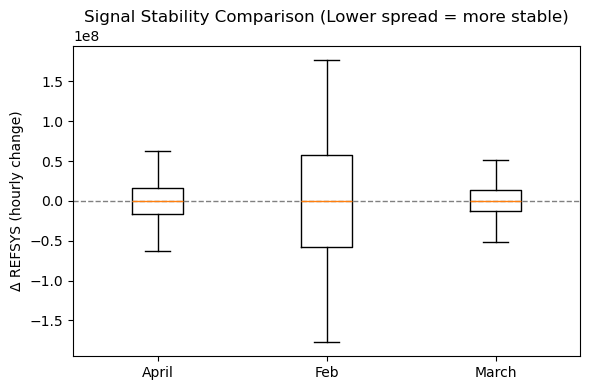

In [84]:
import matplotlib.pyplot as plt
import numpy as np

DT = "DATETIME" if "DATETIME" in hourly_df.columns else "datetime"
M  = "MONTH" if "MONTH" in hourly_df.columns else "month"

# compute short-term fluctuation
hourly_df = hourly_df.sort_values([M, DT])
hourly_df["delta_refsys"] = hourly_df.groupby(M)["REFSYS"].diff()

# stability box data
months = sorted(hourly_df[M].dropna().unique())

stab_boxes = [
    hourly_df.loc[hourly_df[M] == m, "delta_refsys"].dropna()
    for m in months
]

# plot 
plt.figure(figsize=(6,4))
plt.boxplot(stab_boxes, tick_labels=months, showfliers=False)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)

plt.ylabel("Δ REFSYS (hourly change)")
plt.title("Signal Stability Comparison (Lower spread = more stable)")
plt.tight_layout()
plt.show()

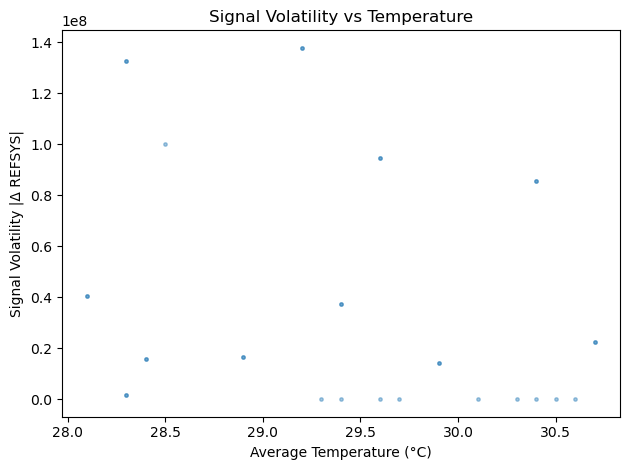

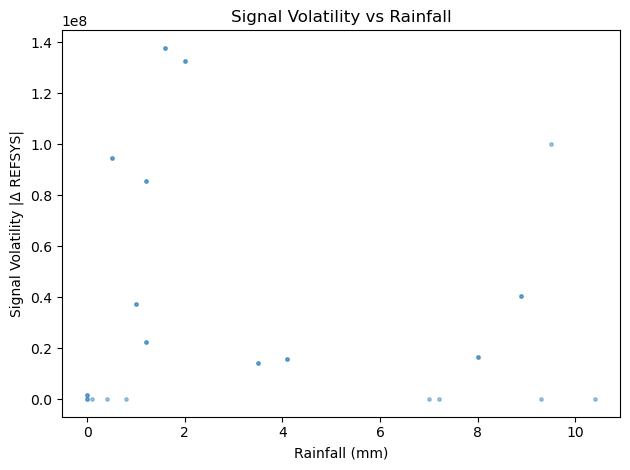

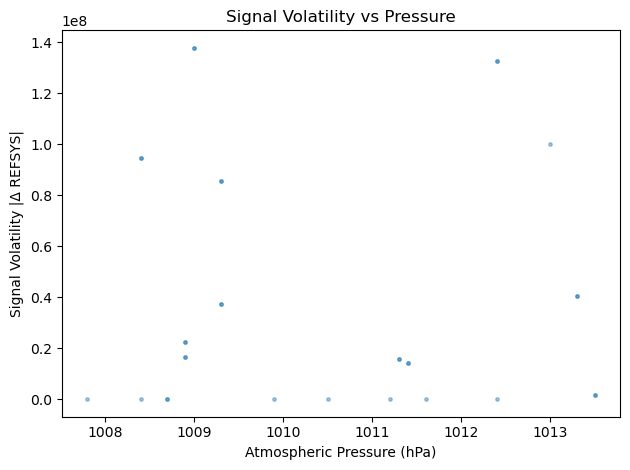

In [85]:
DT = "DATETIME" if "DATETIME" in hourly_df.columns else "datetime"
M  = "MONTH" if "MONTH" in hourly_df.columns else "month"

hourly_df = hourly_df.sort_values([M, DT])
hourly_df["volatility"] = hourly_df.groupby(M)["REFSYS"].diff().abs()

weather_hourly = (
    weather.set_index("datetime")
           .resample("1h")
           .mean(numeric_only=True)
           .reset_index()
)

vol_weather = pd.merge_asof(
    hourly_df.sort_values(DT).rename(columns={DT: "datetime"}),
    weather_hourly.sort_values("datetime"),
    on="datetime",
    tolerance=pd.Timedelta("2h"),
    direction="nearest"
)

vol_weather.head()

vol_weather[["volatility","tavg","prcp","pres","wspd"]].corr()

plt.scatter(vol_weather["tavg"], vol_weather["volatility"], s=6, alpha=0.4)
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Signal Volatility |Δ REFSYS|")
plt.title("Signal Volatility vs Temperature")
plt.tight_layout()
plt.show()

plt.scatter(vol_weather["prcp"], vol_weather["volatility"], s=6, alpha=0.4)
plt.xlabel("Rainfall (mm)")
plt.ylabel("Signal Volatility |Δ REFSYS|")
plt.title("Signal Volatility vs Rainfall")
plt.tight_layout()
plt.show()

plt.scatter(vol_weather["pres"], vol_weather["volatility"], s=6, alpha=0.4)
plt.xlabel("Atmospheric Pressure (hPa)")
plt.ylabel("Signal Volatility |Δ REFSYS|")
plt.title("Signal Volatility vs Pressure")
plt.tight_layout()
plt.show()

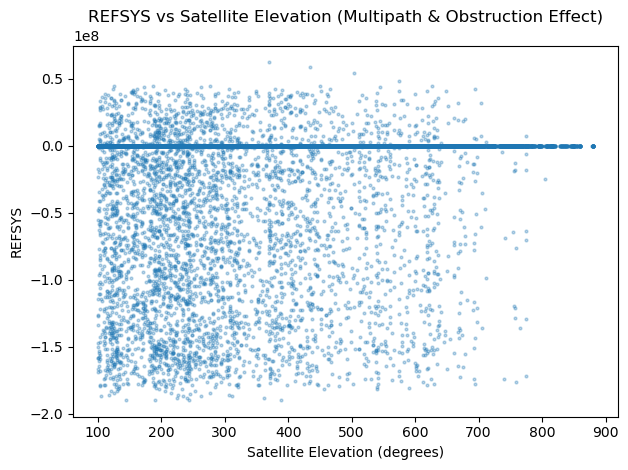

,std,iqr
elv_band,,


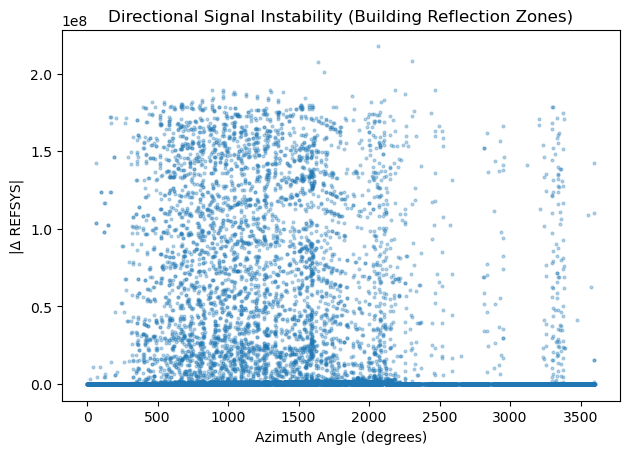

urban_risk
0    3.941018e+07
Name: REFSYS, dtype: float64

In [86]:
plt.scatter(df["ELV"], df["REFSYS"], s=4, alpha=0.3)
plt.xlabel("Satellite Elevation (degrees)")
plt.ylabel("REFSYS")
plt.title("REFSYS vs Satellite Elevation (Multipath & Obstruction Effect)")
plt.tight_layout()
plt.show()

df["elv_band"] = pd.cut(df["ELV"], bins=[0,15,30,45,60,90])

stability_elv = (
   df.groupby("elv_band", observed=True)["REFSYS"]
      .agg(std="std", iqr=lambda x: x.quantile(.75)-x.quantile(.25))
)

display(stability_elv)

df_sorted = df.sort_values(DT)
df_sorted["delta"] = df_sorted.groupby("SAT")["REFSYS"].diff().abs()

plt.scatter(df_sorted["AZTH"], df_sorted["delta"], s=4, alpha=0.3)
plt.xlabel("Azimuth Angle (degrees)")
plt.ylabel("|Δ REFSYS|")
plt.title("Directional Signal Instability (Building Reflection Zones)")
plt.tight_layout()
plt.show()

df["urban_risk"] = (df["ELV"] < 20).astype(int)

df.groupby("urban_risk")["REFSYS"].std()

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

DT_DF = "DATETIME" if "DATETIME" in df.columns else "datetime"
M_DF  = "MONTH" if "MONTH" in df.columns else "month"
D_DF  = "DATASET" if "DATASET" in df.columns else "dataset"

df2 = df.copy()
df2[DT_DF] = pd.to_datetime(df2[DT_DF], errors="coerce")
df2 = df2.dropna(subset=[DT_DF])

agg_df = (
    df2.sort_values(DT_DF)
       .groupby([M_DF, D_DF, DT_DF], as_index=False)["REFSYS"]
       .mean()
)

hourly_df = (
    agg_df.set_index(DT_DF)
          .groupby([M_DF, D_DF])
          .resample("1h")["REFSYS"]
          .mean()
          .reset_index()
)

DT_H = "DATETIME" if "DATETIME" in hourly_df.columns else "datetime"
M_H  = "MONTH" if "MONTH" in hourly_df.columns else "month"
D_H  = "DATASET" if "DATASET" in hourly_df.columns else "dataset"

hourly_df = hourly_df.sort_values([M_H, D_H, DT_H])
hourly_df["volatility"] = hourly_df.groupby([M_H, D_H])["REFSYS"].diff().abs()


elv = pd.to_numeric(df2["ELV"], errors="coerce")

# Heuristic: if max ELV > 90, it's scaled by 10 (tenths of degrees)
if np.nanmax(elv) > 90:
    ELV_DEG = elv / 10.0
else:
    ELV_DEG = elv

df2["ELV_DEG"] = ELV_DEG

# building risk = fraction of low-elevation measurements (more likely blocked/multipath)
df2["building_risk_flag"] = (df2["ELV_DEG"] < 20).astype(float)

building_hourly = (
    df2.rename(columns={DT_DF: "datetime"})
       .dropna(subset=["datetime"])
       .sort_values("datetime")
       .groupby(pd.Grouper(key="datetime", freq="1h"))["building_risk_flag"]
       .mean()
       .reset_index()
       .rename(columns={"building_risk_flag": "building_risk"})
)

print("Check ELV scaling:")
print("ELV raw max:", np.nanmax(elv), "| ELV_DEG max:", np.nanmax(df2["ELV_DEG"]))
print("building_risk hourly non-null ratio:", building_hourly["building_risk"].notna().mean())


weather2 = weather.copy()

# ensure datetime
if "datetime" not in weather2.columns and "date" in weather2.columns:
    weather2["datetime"] = pd.to_datetime(weather2["date"], errors="coerce")
    weather2 = weather2.drop(columns=["date"], errors="ignore")
elif "datetime" in weather2.columns:
    weather2["datetime"] = pd.to_datetime(weather2["datetime"], errors="coerce")
else:
    raise KeyError("weather needs a 'datetime' column or a 'date' column.")

weather2 = weather2.dropna(subset=["datetime"]).sort_values("datetime")

# If weather is daily, resample to hourly and forward-fill (so every hour has weather)
weather_hourly = (
    weather2.set_index("datetime")
            .resample("1h")
            .ffill()
            .reset_index()
)


combo = hourly_df.rename(columns={DT_H: "datetime"}).sort_values("datetime")

combo = pd.merge_asof(
    combo,
    weather_hourly.sort_values("datetime"),
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("24h")  # daily weather needs larger tolerance
)

combo = pd.merge_asof(
    combo.sort_values("datetime"),
    building_hourly.sort_values("datetime"),
    on="datetime",
    direction="nearest",
    tolerance=pd.Timedelta("1h")
)

combo["hour"] = combo["datetime"].dt.hour
combo["period"] = np.where(combo["hour"].between(6, 18), "Day", "Night")

print("\nWeather fill check (non-null %):")
for c in ["tavg", "prcp", "pres", "wspd"]:
    if c in combo.columns:
        print(c, ":", combo[c].notna().mean())

print("\nBuilding risk check (non-null %):", combo["building_risk"].notna().mean())
display(combo[[M_H, D_H, "datetime", "REFSYS", "volatility", "building_risk", "hour", "period"]].head())


# A) Volatility by month AND dataset (reproducibility check)
vol_month_set = combo.groupby([M_H, D_H])["volatility"].mean().unstack()
display(vol_month_set)

# B) Volatility vs building risk bins
combo["bld_bin"] = pd.cut(combo["building_risk"], bins=[-0.01, 0.1, 0.3, 0.6, 1.0],
                          labels=["Very Low", "Low", "Medium", "High"], include_lowest=True)
vol_by_bld = combo.groupby([M_H, "bld_bin"], observed=True)["volatility"].mean().unstack()
display(vol_by_bld)

# C) Rain vs no-rain volatility (threshold)
if "prcp" in combo.columns:
    combo["rain_flag"] = (pd.to_numeric(combo["prcp"], errors="coerce").fillna(0) > 0).astype(int)
    vol_rain = combo.groupby([M_H, "rain_flag"])["volatility"].mean().unstack()
    vol_rain.columns = ["No Rain", "Rain"]
    display(vol_rain)

# D) Day vs night volatility by month
day_night = combo.groupby([M_H, "period"])["volatility"].mean().unstack()
display(day_night)


predictors = [c for c in ["building_risk", "hour", "tavg", "prcp", "pres", "wspd"] if c in combo.columns]
model_df = combo.dropna(subset=predictors + ["volatility"]).copy()

print("\nRows available for regression:", len(model_df))
if len(model_df) >= 50:
    X = model_df[predictors]
    y = model_df["volatility"]
    lr = LinearRegression()
    lr.fit(X, y)
    coef = pd.Series(lr.coef_, index=predictors).sort_values(key=np.abs, ascending=False)
    print("Regression coefficients (abs bigger = stronger effect):")
    display(coef)
else:
    print("Still not enough rows after dropping NaNs. Increase tolerance or check weather columns.")


Check ELV scaling:
ELV raw max: 881 | ELV_DEG max: 88.1
building_risk hourly non-null ratio: 0.40298507462686567

Weather fill check (non-null %):
tavg : 1.0
prcp : 1.0
pres : 1.0
wspd : 1.0

Building risk check (non-null %): 1.0


,month,dataset,datetime,REFSYS,volatility,building_risk,hour,period
0,Feb,Set 2,2024-02-03 00:00:00,-4.278571e+00,NaN,0.153846,0,Night
1,Feb,Set 1,2024-02-03 00:00:00,-1.000195e+08,NaN,0.153846,0,Night
2,Feb,Set 1,2024-02-03 01:00:00,-1.039954e+08,3.975954e+06,0.179487,1,Night
3,Feb,Set 2,2024-02-03 01:00:00,7.220238e+00,1.149881e+01,0.179487,1,Night
4,Feb,Set 1,2024-02-03 02:00:00,-1.074440e+08,3.448536e+06,0.200000,2,Night


dataset,Set 1,Set 2
month,,
April,1.106732e+07,16.828154
Feb,5.452872e+06,25.488140
March,1.000410e+07,67732.077156


bld_bin,Very Low,Low,Medium
month,,,
April,364697.782547,3.782814e+06,1.579133e+06
Feb,891782.643836,2.798596e+06,1.919099e+06
March,709667.794163,3.161918e+06,1.993585e+06


,No Rain,Rain
month,,
April,1.622847e+01,3.291274e+06
Feb,1.732522e+06,2.643967e+06
March,4.126340e+06,2.341050e+06


period,Day,Night
month,,
April,2.431955e+06,3.882913e+06
Feb,3.165704e+06,1.515409e+06
March,3.862590e+06,1.104442e+06



Rows available for regression: 948
Regression coefficients (abs bigger = stronger effect):


building_risk   -4.969953e+06
tavg            -1.535602e+06
pres            -6.313226e+05
prcp            -1.821904e+05
hour             1.226982e+05
wspd            -1.062338e+05
dtype: float64

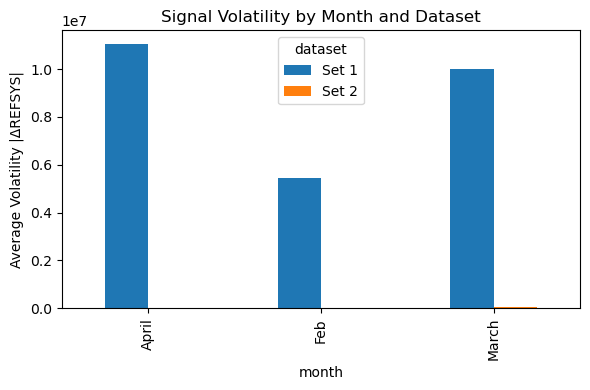

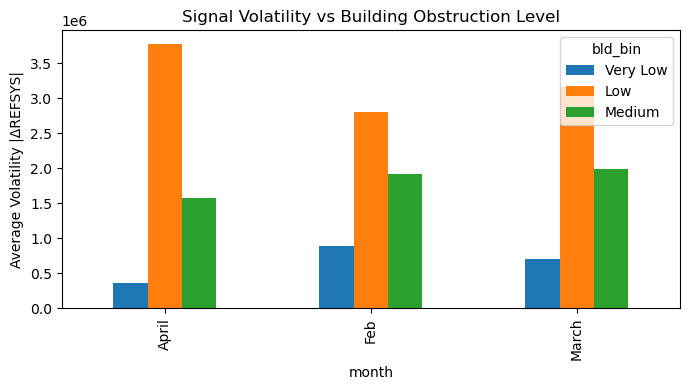

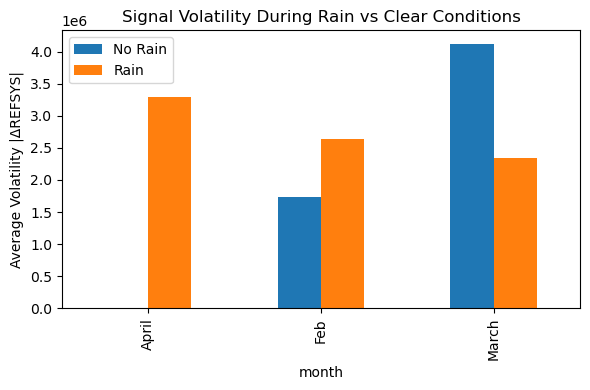

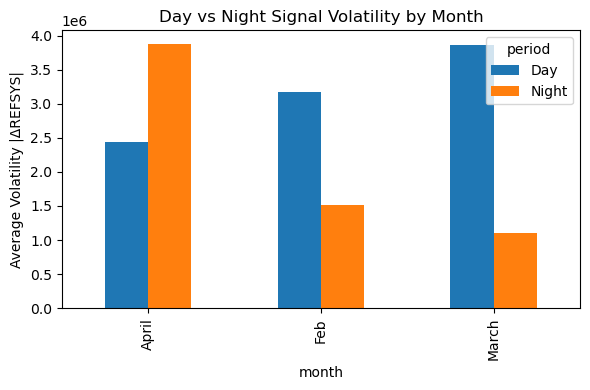

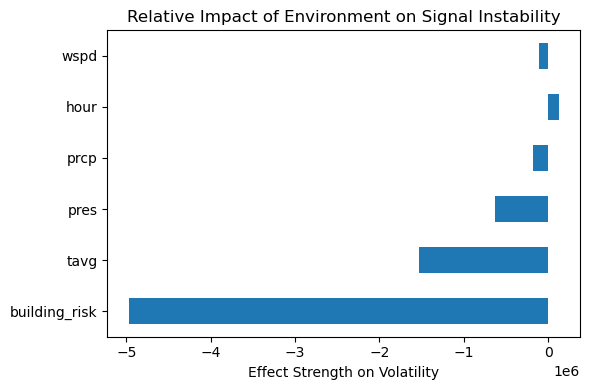

In [88]:
vol_month_set.plot(kind="bar", figsize=(6,4))
plt.ylabel("Average Volatility |ΔREFSYS|")
plt.title("Signal Volatility by Month and Dataset")
plt.tight_layout()
plt.show()

vol_by_bld.plot(kind="bar", figsize=(7,4))
plt.ylabel("Average Volatility |ΔREFSYS|")
plt.title("Signal Volatility vs Building Obstruction Level")
plt.tight_layout()
plt.show()

vol_rain.plot(kind="bar", figsize=(6,4))
plt.ylabel("Average Volatility |ΔREFSYS|")
plt.title("Signal Volatility During Rain vs Clear Conditions")
plt.tight_layout()
plt.show()

day_night.plot(kind="bar", figsize=(6,4))
plt.ylabel("Average Volatility |ΔREFSYS|")
plt.title("Day vs Night Signal Volatility by Month")
plt.tight_layout()
plt.show()

coef.plot(kind="barh", figsize=(6,4))
plt.xlabel("Effect Strength on Volatility")
plt.title("Relative Impact of Environment on Signal Instability")
plt.tight_layout()
plt.show()